In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from itertools import product
import json 

import pprint
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from preprocessor import get_train_environment

# Tune n_estimators & max_depth for XGBClassifier

In [15]:
# Define parameter grid
n_estimators = list(range(60, 120, 10))
max_depth = list(range(3, 6, 1))
param_grid = [(n, d) for n in n_estimators for d in max_depth]

# Initialize variables to track the best parameters
best_params = None
best_score = 0
model_performance = []

# Iterate over folds
envGen = get_train_environment(n_splits=5)
stats, X, X_holdout, y, y_holdout = next(envGen)

xgb_performances = {}

# Iterate over all combinations of parameters
for fold, stats, X_train, X_test, y_train, y_test in envGen:
    f1_scores = []
    print(fold)
    
    for n, d in param_grid:
        print(n, d)
        class_y_train = [0 if value == 0 else 1 for value in y_train]
        class_y_test = [0 if value == 0 else 1 for value in y_test]
        # Create and fit the model
        model = XGBClassifier(n_estimators=n, max_depth=d)
        model.fit(X_train, class_y_train)

        # Predict and evaluate
        predictions = model.predict(X_test)

        f1 = f1_score(class_y_test, predictions, average='weighted')
        
        if (n, d) in xgb_performances:
            xgb_performances[(n, d)].append(f1)
        else:
            xgb_performances[(n, d)] = [f1]
print(xgb_performances)

Found cached folds, using those
0
60 3
60 4
60 5
70 3
70 4
70 5
80 3
80 4
80 5
90 3
90 4
90 5
100 3
100 4
100 5
110 3
110 4
110 5
1
60 3
60 4
60 5
70 3
70 4
70 5
80 3
80 4
80 5
90 3
90 4
90 5
100 3
100 4
100 5
110 3
110 4
110 5
2
60 3
60 4
60 5
70 3
70 4
70 5
80 3
80 4
80 5
90 3
90 4
90 5
100 3
100 4
100 5
110 3
110 4
110 5
3
60 3
60 4
60 5
70 3
70 4
70 5
80 3
80 4
80 5
90 3
90 4
90 5
100 3
100 4
100 5
110 3
110 4
110 5
4
60 3
60 4
60 5
70 3
70 4
70 5
80 3
80 4
80 5
90 3
90 4
90 5
100 3
100 4
100 5
110 3
110 4
110 5
{(60, 3): [0.9651931496841945, 0.963283865681619, 0.9648102535936771, 0.9687644941844269, 0.9646432683260762], (60, 4): [0.9674309703141039, 0.9643120343435644, 0.9664602318959495, 0.9666694315416943, 0.9652734228579537], (60, 5): [0.9674782798191829, 0.9639017323743847, 0.965893015021564, 0.9678573801350902, 0.9648171895057409], (70, 3): [0.9651414059279912, 0.963283865681619, 0.965893015021564, 0.9681976218760108, 0.9630420887336885], (70, 4): [0.9663631332752218, 0.96487

In [9]:
toplot = {x: np.mean(xgb_performances[x]) for x in xgb_performances}

In [10]:
toplot

{(20, 3): 0.9628723943398676,
 (20, 4): 0.9644397530604328,
 (20, 5): 0.964273437440798,
 (40, 3): 0.9647788489469825,
 (40, 4): 0.9657934995087615,
 (40, 5): 0.9652648773352022,
 (60, 3): 0.9653390062939987,
 (60, 4): 0.9660292181906531,
 (60, 5): 0.9659895193711925,
 (80, 3): 0.9655380614381045,
 (80, 4): 0.9660564584655049,
 (80, 5): 0.9658819007738633,
 (100, 3): 0.9661126807646216,
 (100, 4): 0.9652135872804856,
 (100, 5): 0.9658970779589213,
 (300, 3): 0.9648707985067151,
 (300, 4): 0.9637365225483583,
 (300, 5): 0.9657072141316683,
 (500, 3): 0.9634284553797317,
 (500, 4): 0.9624429086425762,
 (500, 5): 0.96464153601499}

In [11]:
df = pd.DataFrame.from_dict([{"n_est": k[0], "depth": k[1], "f1": v} for k, v in toplot.items()])

<Axes: xlabel='n_est', ylabel='f1'>

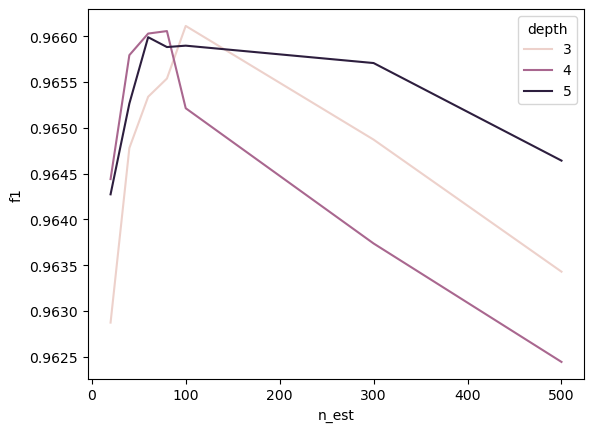

In [14]:
sns.lineplot(x="n_est", y="f1", hue="depth", data=df)

In [ ]:
# Aggregate f1 values for each (n_estimators, max_depth) pair
f1_aggregate = {}

for entry in model_performance:
    key = (entry['n_estimators'], entry['max_depth'])
    if key not in f1_aggregate:
        f1_aggregate[key] = []
    f1_aggregate[key].append(entry['f1'])

# Calculate average f1 for each pair
average_f1 = {k: sum(v)/len(v) for k, v in f1_aggregate.items()}

# Prepare data for plotting
n_estimators = [k[0] for k in average_f1.keys()]
max_depth = [k[1] for k in average_f1.keys()]
avg_f1 = list(average_f1.values())

#plt.figure(figsize=(28,9))
plt.scatter(range(len(avg_f1)), avg_f1)
plt.xlabel('Parameter Pair (n_estimators / max_depth)')
plt.ylabel('Average f1')
plt.title('(XGBClassifier)Average f1 for Each Parameter Pair')
plt.show()

In [ ]:
df = pd.DataFrame([{'n_estimators': k[0], 'max_depth': k[1], 'f1_score': v} for k, v in average_f1.items()])

for depth in sorted(df['max_depth'].unique()):
    subset = df[df['max_depth'] == depth]
    plt.plot(subset['n_estimators'], subset['f1_score'], label=f'Max Depth: {depth}')
plt.xlabel('n_estimators')
plt.ylabel('F1 Score')
plt.title('(XGBClassifier)Average F1 Scores for Each Parameter Pair')
plt.legend()
plt.show()

In [ ]:

print(f"Best parameters: n_estimators={best_params[0]}, max_depth={best_params[1]} with f1: {best_score}")

# Compare differernt loss function's f1

In [ ]:
# envGen = get_train_environment(n_splits=10)
# results = []
# # The holdout set is not included in the cross validation folds, use it at the very end to evaluate overall performance
# stats, X, X_holdout, y, y_holdout = next(envGen)

# featureNums = range(1, len(X[0]), 10)

# featureNumf1s = {}


# for fold, stats, X_train_fold, X_test_fold, y_train_fold, y_test_fold in envGen:
#     f1_scores1 = []
#     f1_scores2 = []
#     print(f"Fold: {fold}")
#     class_y_train_fold = [0 if value == 0 else 1 for value in y_train_fold]
#     class_y_test_fold = [0 if value == 0 else 1 for value in y_test_fold]
    
#     model1 = XGBClassifier(n_estimators=best_params[0], max_depth=best_params[1], objective='binary:logistic') #Default
#     model1.fit(X_train_fold, class_y_train_fold)
#     predictions1 = model1.predict(X_test_fold)  
    
#     model2 = XGBClassifier(n_estimators=best_params[0], max_depth=best_params[1], objective='binary:hinge')
#     model2.fit(X_train_fold, class_y_train_fold)
#     predictions2 = model2.predict(X_test_fold)

#     f11 = f1_score(class_y_test_fold, predictions1, average='weighted')
#     f12 = f1_score(class_y_test_fold, predictions2, average='weighted')
#     f1_scores1.append(f11)
#     f1_scores2.append(f12)
    
# print(np.mean(f1_scores1))
# print(np.mean(f1_scores2))

# Find important feature

In [ ]:
best_params

In [ ]:
envGen = get_train_environment(n_splits=5)
# The holdout set is not included in the cross validation folds, use it at the very end to evaluate overall performance
stats, X, X_holdout, y, y_holdout = next(envGen)

# Initialize variables to track important features num
print(len(X[0]))
featureNums = range(1, len(X[0]), 10)
featureNumf1s = {}

# Cross validation folds
for fold, stats, X_train, X_test, y_train, y_test in envGen:
    print(f"Fold: {fold}")
    class_y_train = [0 if value == 0 else 1 for value in y_train]
    class_y_test = [0 if value == 0 else 1 for value in y_test]
    
    model = XGBClassifier(n_estimators=best_params[0], max_depth=best_params[1])
    model.fit(X_train, class_y_train)

    # print(model.feature_importances_)
    # make predictions for test data and evaluate
    predictions = model.predict(X_test)
    f1 = f1_score(class_y_test, predictions, average='weighted')
    print("Overall Fold Mean Squared Error: ", f1)
    
    thresholds = enumerate(model.feature_importances_)
    thresholds = [x for x in thresholds]
    thresholds.sort(key=lambda x: x[1], reverse=True)
    
    eps = 0.000001
    lastf1 = None
    for featureNum in featureNums:
        selectedFeatures = [i for i, x in thresholds[:featureNum]]
        
        model = XGBClassifier(n_estimators=best_params[0], max_depth=best_params[1])
        XT = X_train[:, selectedFeatures]
        model.fit(XT, class_y_train)
        
        predictions = model.predict(X_test[:, selectedFeatures])
        f1 = f1_score(class_y_test, predictions, average='weighted')
        
        if lastf1 is not None:
            if np.abs(f1 - lastf1) < eps:
                print(np.abs(f1 - lastf1))
                print(f1)
                break
            else:
                lastf1 = f1
        else:
            lastf1 = f1
        
        if featureNum in featureNumf1s:
            featureNumf1s[featureNum].append(f1)
        else:
            featureNumf1s[featureNum] = [f1]
        
        print(f"FeatureNum: {featureNum}")
        print("FeatureNum Mean Squared Error: ", f1)



In [ ]:
avgFeatureNumf1s = {x: np.mean(featureNumf1s[x]) for x in featureNumf1s}
optimal_FeatureNum = [max(avgFeatureNumf1s, key=avgFeatureNumf1s.get),avgFeatureNumf1s[max(avgFeatureNumf1s, key=avgFeatureNumf1s.get)]]
print("Optimal # of features: ",optimal_FeatureNum[0],", f1: ",optimal_FeatureNum[1])

In [ ]:
ax = sns.lineplot(pd.Series(avgFeatureNumf1s))
ax.set_xlabel("Num of Features")
ax.set_ylabel("Test f1")
ax.set_title("XGBoost Classifier feature number vs f1")

# Create final model after tuning & select important features

In [ ]:
envGen = get_train_environment(n_splits=50)
# The holdout set is not included in the cross validation folds, use it at the very end to evaluate overall performance
stats, X, X_holdout, y, y_holdout = next(envGen)

final_f1s = []
final_selection_intersection = set()
allSelecteds = []

# Cross validation folds
for fold, stats, X_train_fold, X_test_fold, y_train_fold, y_test_fold in envGen:
    print(f"Fold: {fold}")
    class_y_train = [0 if value == 0 else 1 for value in y_train_fold]
    class_y_test = [0 if value == 0 else 1 for value in y_test_fold]
    
    model = XGBClassifier(n_estimators=best_params[0], max_depth=best_params[1])
    model.fit(X_train_fold, class_y_train)

    print(model.feature_importances_)
    # make predictions for test data and evaluate
    pre_predictions = model.predict(X_test_fold)

    pre_f1 = f1_score(class_y_test, pre_predictions)
    print("Pre Selection f1: ", pre_f1)
    
    thresholds = enumerate(model.feature_importances_)
    thresholds = [x for x in thresholds]
    thresholds.sort(key=lambda x: x[1], reverse=True)
    
    selectedFeatures = [i for i, x in thresholds[:optimal_FeatureNum[0]]]
    allSelecteds.append(selectedFeatures)
    
    if len(final_selection_intersection) == 0:
        final_selection_intersection = final_selection_intersection.union(selectedFeatures)
    else:
        final_selection_intersection = final_selection_intersection.intersection(selectedFeatures)
    
    model = XGBClassifier(n_estimators=best_params[0], max_depth=best_params[1])
    
    XT = X_train_fold[:, selectedFeatures]
    model.fit(XT, class_y_train)

    post_predictions = model.predict(X_test_fold[:, selectedFeatures])
    post_f1 = f1_score(class_y_test, post_predictions)
    print("Post Selection f1: ", post_f1)
    final_f1s.append(post_f1)

In [ ]:
print(np.mean(final_f1s))

In [ ]:
ax = sns.histplot(final_f1s)
ax.set_xlabel("Test f1")
ax.set_title("Final XGBoost Classifier Model CV Results")

In [ ]:
print("Num of selected features: ",optimal_FeatureNum[0], "n_estimator:", best_params[0],"max_dapth: ",best_params[1])

In [ ]:
def feature_labels(features):
    data = pd.read_csv("FinalData.csv")
    data = data.drop(["Name", "appid", 'ln.pricep1', "Unnamed: 0"], axis=1)
    data_columns = data.columns.tolist()
    return [x for i, x in enumerate(data_columns) if i in features]

In [ ]:
xgb_class_final_features = feature_labels(final_selection_intersection)

In [ ]:
xgb_class_final_features